In [1]:
import numpy as np

In [2]:
import polars as pl

schema_overrides = {
    'tip_amount': pl.Float64,
    'tolls_amount': pl.Float64
}

month_feb_2016 = pl.read_csv('DataSets/yellow_tripdata_2016-02.csv', schema_overrides = schema_overrides)
total_records = month_feb_2016.shape[0]

In [3]:
month_feb_2016.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'pickup_longitude',
 'pickup_latitude',
 'RatecodeID',
 'store_and_fwd_flag',
 'dropoff_longitude',
 'dropoff_latitude',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount']

In [4]:
import polars as pl
import folium

# Define NYC bounding box
min_lat, max_lat = 40.4774, 40.9176
min_lon, max_lon = -74.2591, -73.7004

# Assuming your DataFrame is named "month_jan_2016"
df = month_feb_2016.select(["pickup_latitude", "pickup_longitude"]).drop_nulls()

# Convert to Pandas since Folium doesn't support Polars directly
sampled_df = df.sample(n=500, seed=42).to_pandas()

# Identify outliers
sampled_df["is_outlier"] = ~((sampled_df["pickup_latitude"].between(min_lat, max_lat)) & 
                             (sampled_df["pickup_longitude"].between(min_lon, max_lon)))

# Create NYC map
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Add points to the map
for _, row in sampled_df.iterrows():
    color = "red" if row["is_outlier"] else "blue"
    folium.CircleMarker(
        location=[row["pickup_latitude"], row["pickup_longitude"]],
        radius=1,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.5
    ).add_to(nyc_map)

In [5]:
import polars as pl
import datetime

# Convert timestamps into Unix Time
def convert_to_unix(s: str) -> float:
    return datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timestamp()

# Function to calculate trip times and speeds
def return_with_trip_times(month_feb_2016):
    month_feb_2016 = month_feb_2016.with_columns([
        pl.col("tpep_pickup_datetime").map_elements(convert_to_unix, return_dtype=pl.Float64).alias("pickup_unix"),
        pl.col("tpep_dropoff_datetime").map_elements(convert_to_unix, return_dtype=pl.Float64).alias("dropoff_unix")
    ])

    # Compute trip duration in minutes
    month_feb_2016 = month_feb_2016.with_columns(
        ((pl.col("dropoff_unix") - pl.col("pickup_unix")) / 60).alias("trip_times")
    )

    # Avoid division by zero: Replace zero trip_times with NaN before calculating Speed
    month_feb_2016 = month_feb_2016.with_columns(
        pl.when(pl.col("trip_times") == 0)
          .then(None)
          .otherwise(pl.col("trip_times"))
          .alias("trip_times")
    )

    # Compute speed (handling division by zero)
    month_feb_2016 = month_feb_2016.with_columns(
        ((60 * pl.col("trip_distance").cast(pl.Float64)) / pl.col("trip_times")).alias("speed")
    )

    return month_feb_2016

# Apply function
month_feb_2016_modified = return_with_trip_times(month_feb_2016)

In [6]:
month_feb_2016_modified.filter(
    (pl.col("trip_times") > 0) & 
    (~pl.col("speed").is_null()) &
    (~(pl.col("speed") == float("inf")))
).head()

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_unix,dropoff_unix,trip_times,speed
i64,str,str,i64,f64,f64,f64,i64,str,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,"""2016-02-25 17:24:20""","""2016-02-25 17:27:20""",2,0.7,-73.94725,40.763771,1,"""N""",-73.992012,40.73539,2,5.0,0.0,0.5,0.0,0.0,0.3,5.8,1.4564e9,1.4564e9,3.0,14.0
2,"""2016-02-25 23:10:50""","""2016-02-25 23:31:50""",2,5.52,-73.983017,40.750992,1,"""N""",-73.988586,40.758839,2,20.0,0.5,0.5,0.0,0.0,0.3,21.3,1.4564e9,1.4564e9,21.0,15.771429
2,"""2016-02-01 00:00:01""","""2016-02-01 00:10:52""",6,1.99,-73.99234,40.758202,1,"""N""",-73.964355,40.757977,1,9.5,0.5,0.5,0.7,0.0,0.3,11.5,1.4543e9,1.4543e9,10.85,11.004608
1,"""2016-02-01 00:00:04""","""2016-02-01 00:05:16""",1,1.5,-73.981453,40.749722,1,"""N""",-73.982323,40.763985,2,6.5,0.5,0.5,0.0,0.0,0.3,7.8,1.4543e9,1.4543e9,5.2,17.307692
2,"""2016-02-01 00:00:05""","""2016-02-01 00:20:59""",1,5.6,-74.000603,40.729755,1,"""N""",-73.951324,40.669834,1,20.0,0.5,0.5,4.0,0.0,0.3,25.3,1.4543e9,1.4543e9,20.9,16.076555


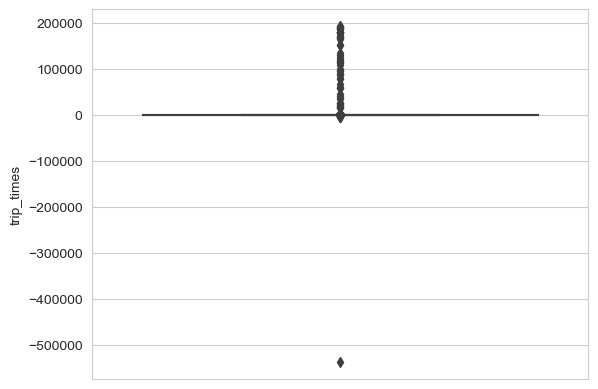

In [7]:
# Calculate the percentiles to remove outliers, and check with BoxPlots
import seaborn as sns
import matplotlib.pyplot as plt

# Convert Polars DataFrame to Pandas for plotting
sns.boxplot(data = month_feb_2016_modified.to_pandas(), y = "trip_times")
plt.show()

In [8]:
deciles = [i / 10 for i in range(1, 11)]

decile_values = month_feb_2016_modified.select([
    pl.col("trip_times").quantile(q).alias(f"{int(q * 100)}th") for q in deciles
])

# Convert to dictionary and print nicely
for col in decile_values.columns:
    value = decile_values[0, col]
    print(f"{col} percentile is {value:.2f}")

10th percentile is 3.95
20th percentile is 5.60
30th percentile is 7.15
40th percentile is 8.77
50th percentile is 10.57
60th percentile is 12.68
70th percentile is 15.33
80th percentile is 19.05
90th percentile is 25.50
100th percentile is 192313.38


In [9]:
print(month_feb_2016_modified.shape)

(11382049, 23)


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


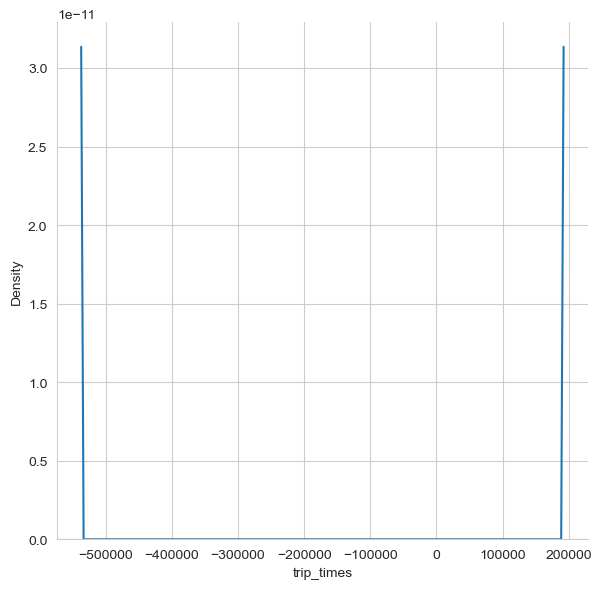

In [10]:
# Ploting PDF
sns.FacetGrid(month_feb_2016_modified.to_pandas(), height = 6)\
    .map(sns.kdeplot, 'trip_times')\
    .add_legend();
# plt.xlim(-5000, 60000);
plt.show();

In [11]:
from math import sqrt
month_feb_2016_modified = month_feb_2016_modified.with_columns(pl.col('trip_times').map_elements(lambda x: sqrt(x) if x > 0 else None).alias("log_trip_times"))

/var/folders/xt/dsl_68w51jzftxq18_hpfkhm0000gn/T/ipykernel_98559/2289420779.py:2: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  month_feb_2016_modified = month_feb_2016_modified.with_columns(pl.col('trip_times').map_elements(lambda x: sqrt(x) if x > 0 else None).alias("log_trip_times"))


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


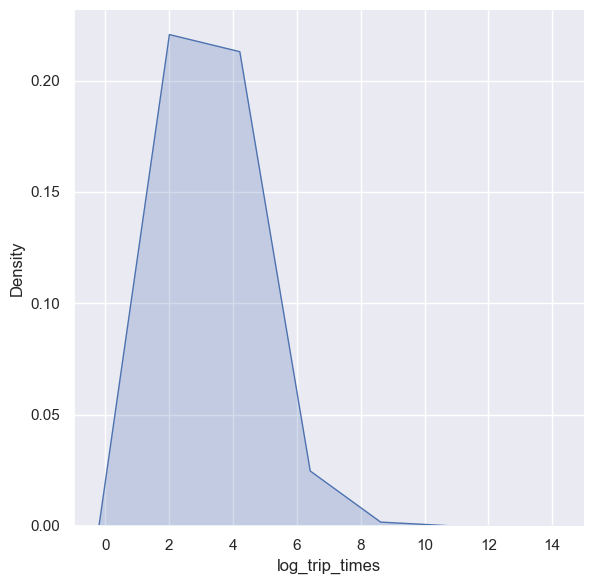

In [12]:
sns.set(style="darkgrid") 
sns.FacetGrid(month_feb_2016_modified.to_pandas(), height = 6)\
    .map(sns.kdeplot, 'log_trip_times', bw_adjust = 1.5, fill = True)\
    .add_legend();
plt.xlim(-1, 15)
plt.show();

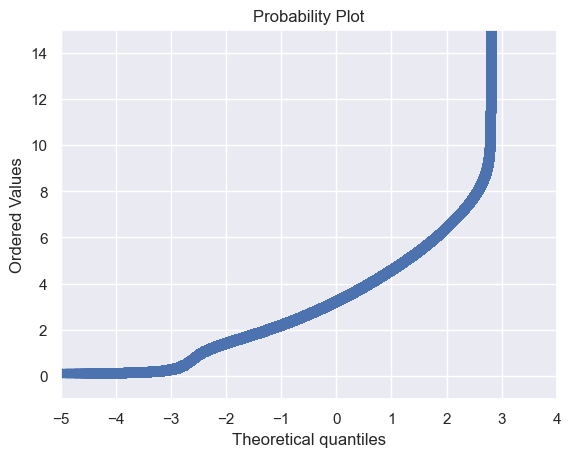

In [13]:
import scipy.stats as scs

scs.probplot(month_feb_2016_modified['log_trip_times'].to_numpy(), plot = plt)
plt.ylim(-1, 15)
plt.xlim(-5, 4)
plt.show()

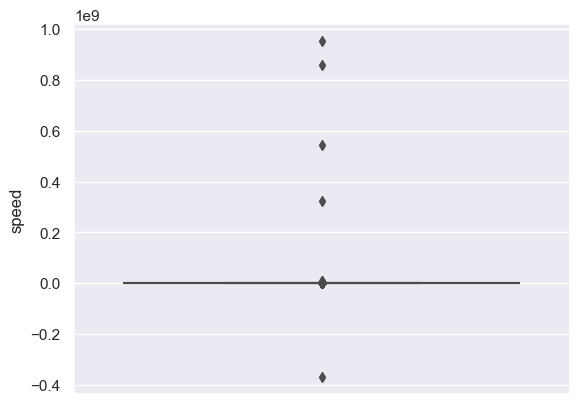

In [14]:
import seaborn as sns
sns.boxplot(month_feb_2016_modified.to_pandas(), y = 'speed');
plt.show()

In [15]:
speed = month_feb_2016_modified["speed"].cast(pl.Float64).drop_nulls().to_numpy()
deciles = list(range(10, 101, 10))
percentile_values = np.percentile(speed, deciles)

for i, val in zip(deciles, percentile_values):
    print(f'{i}th Percentile: {val}')

10th Percentile: 5.885558583106268
20th Percentile: 7.251184834123223
30th Percentile: 8.346020761245676
40th Percentile: 9.381818181818183
50th Percentile: 10.461538461538462
60th Percentile: 11.685427910562836
70th Percentile: 13.215189873417723
80th Percentile: 15.428571428571427
90th Percentile: 19.711299153807865
100th Percentile: 952524000.0


In [16]:
percentiles = [i + 90 for i in range(0, 11)]
percentile_values = np.percentile(speed, percentiles)

for j, i in enumerate(range(90, 101)):
    print(f'{i}th Percentile: {percentile_values[j]}')

90th Percentile: 19.711299153807865
91th Percentile: 20.43243243243243
92th Percentile: 21.261261261261264
93th Percentile: 22.22222222222222
94th Percentile: 23.326133909287257
95th Percentile: 24.632384190395243
96th Percentile: 26.21584529220153
97th Percentile: 28.235294117647058
98th Percentile: 31.006097560975608
99th Percentile: 35.44401840452952
100th Percentile: 952524000.0


In [17]:
percentiles = [i / 10 for i in range(991, 1001)]
percentile_values = np.percentile(speed, percentiles)

for j, p in enumerate(percentiles):
    print(f'{p}th Percentile: {percentile_values[j]}')

99.1th Percentile: 36.06163806859471
99.2th Percentile: 36.759112204645355
99.3th Percentile: 37.524512494352855
99.4th Percentile: 38.3858360220079
99.5th Percentile: 39.392098716627345
99.6th Percentile: 40.59167404782994
99.7th Percentile: 42.122229857642374
99.8th Percentile: 44.37976265338167
99.9th Percentile: 52.00000000000001
100.0th Percentile: 952524000.0


In [18]:
month_feb_2016_modified = month_feb_2016_modified.filter(
    (pl.col('trip_distance').is_not_null()) &
    (pl.col('speed') >= 0) & 
    (pl.col("speed") <= 52))
speed_record_loss = total_records - month_feb_2016_modified.shape[0]
speed_record_loss

23660

In [19]:
# Average Speed in NYC 
print(month_feb_2016_modified['speed'].mean());

11.869928455914243


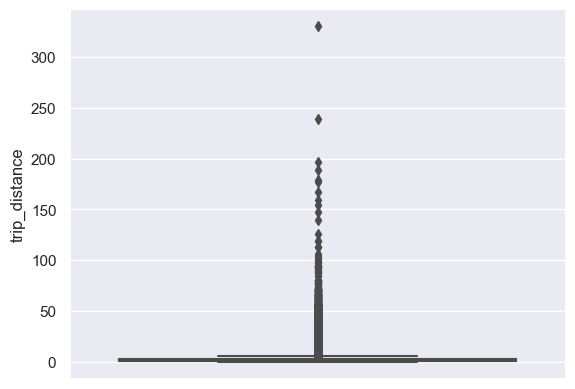

In [20]:
sns.boxplot(month_feb_2016_modified.to_pandas(), y = 'trip_distance');
plt.show()

In [21]:
trip_distances = month_feb_2016_modified["speed"].to_pandas()
deciles = [i * 10 for i in range(1, 11)]
percentile_values = np.percentile(trip_distances, deciles)

for j, i in enumerate(range(10, 101, 10)):
    print(f'{i}th Percentile: {percentile_values[j]}')
    
print('================================================================================================\n')

percentiles = [i + 90 for i in range(0, 11)]
percentile_values = np.percentile(trip_distances, percentiles)

for j, i in enumerate(range(90, 101)):
    print(f'{i}th Percentile: {percentile_values[j]}')
    
print('================================================================================================\n')

percentiles = [i / 10 for i in range(991, 1001)]
percentile_values = np.percentile(trip_distances, percentiles)

for j, p in enumerate(percentiles):
    print(f'{p}th Percentile: {percentile_values[j]}')



10th Percentile: 5.88410104011887
20th Percentile: 7.248322147651007
30th Percentile: 8.342989571263036
40th Percentile: 9.377713458755428
50th Percentile: 10.45643153526971
60th Percentile: 11.675675675675677
70th Percentile: 13.203166226912927
80th Percentile: 15.402885682574919
90th Percentile: 19.64788732394366
100th Percentile: 52.0

90th Percentile: 19.64788732394366
91th Percentile: 20.364963503649637
92th Percentile: 21.176470588235293
93th Percentile: 22.125
94th Percentile: 23.218934911242602
95th Percentile: 24.49905482041588
96th Percentile: 26.048969662534088
97th Percentile: 28.011994002998502
98th Percentile: 30.687562706990345
99th Percentile: 34.86938411170294
100th Percentile: 52.0

99.1th Percentile: 35.44954128440367
99.2th Percentile: 36.0655737704918
99.3th Percentile: 36.76313731572129
99.4th Percentile: 37.529810475287015
99.5th Percentile: 38.38976857490865
99.6th Percentile: 39.39699528713766
99.7th Percentile: 40.595679762493496
99.8th Percentile: 42.12526764

In [22]:
percentiles = np.round(np.append(np.arange(99.90, 100.0, 0.01), 100.0), 2)

percentile_values = np.percentile(trip_distances, percentiles)

for j, p in enumerate(percentiles):
    print(f'{p:.2f}th Percentile: {percentile_values[j]}')

99.90th Percentile: 44.38335343658321
99.91th Percentile: 44.6966838925746
99.92th Percentile: 45.00721673936593
99.93th Percentile: 45.40546749000293
99.94th Percentile: 45.843341536595226
99.95th Percentile: 46.31025413397584
99.96th Percentile: 46.87145178002857
99.97th Percentile: 47.55021915407851
99.98th Percentile: 48.42365309462914
99.99th Percentile: 49.702371289072644
100.00th Percentile: 52.0


In [23]:
month_feb_2016_modified = month_feb_2016_modified.filter(
    (pl.col('trip_distance').is_not_null()) &
    (pl.col('trip_distance') >= 0) &
    (pl.col('trip_distance') <= 44)
)
trip_distances_record_loss = total_records - month_feb_2016_modified.shape[0]
trip_distances_record_loss

24169

In [24]:
month_feb_2016_modified.head(5)

VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_unix,dropoff_unix,trip_times,speed,log_trip_times
i64,str,str,i64,f64,f64,f64,i64,str,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2,"""2016-02-25 17:24:20""","""2016-02-25 17:27:20""",2,0.7,-73.94725,40.763771,1,"""N""",-73.992012,40.73539,2,5.0,0.0,0.5,0.0,0.0,0.3,5.8,1.4564e9,1.4564e9,3.0,14.0,1.732051
2,"""2016-02-25 23:10:50""","""2016-02-25 23:31:50""",2,5.52,-73.983017,40.750992,1,"""N""",-73.988586,40.758839,2,20.0,0.5,0.5,0.0,0.0,0.3,21.3,1.4564e9,1.4564e9,21.0,15.771429,4.582576
2,"""2016-02-01 00:00:01""","""2016-02-01 00:10:52""",6,1.99,-73.99234,40.758202,1,"""N""",-73.964355,40.757977,1,9.5,0.5,0.5,0.7,0.0,0.3,11.5,1.4543e9,1.4543e9,10.85,11.004608,3.293934
1,"""2016-02-01 00:00:04""","""2016-02-01 00:05:16""",1,1.5,-73.981453,40.749722,1,"""N""",-73.982323,40.763985,2,6.5,0.5,0.5,0.0,0.0,0.3,7.8,1.4543e9,1.4543e9,5.2,17.307692,2.280351
2,"""2016-02-01 00:00:05""","""2016-02-01 00:20:59""",1,5.6,-74.000603,40.729755,1,"""N""",-73.951324,40.669834,1,20.0,0.5,0.5,4.0,0.0,0.3,25.3,1.4543e9,1.4543e9,20.9,16.076555,4.571652


In [25]:
month_feb_2016_modified.shape

(11357880, 24)

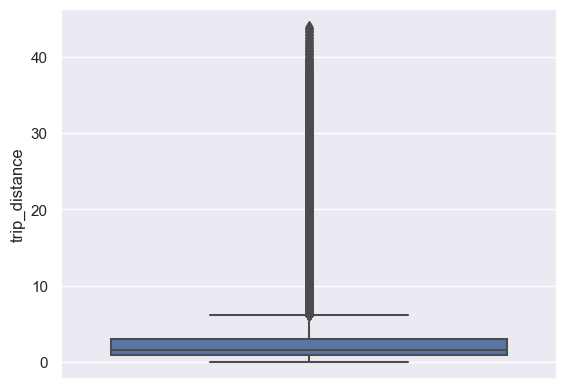

In [26]:
sns.boxplot(data = month_feb_2016_modified.to_pandas(), y = 'trip_distance')
plt.show()

In [27]:
trip_distances = month_feb_2016_modified['trip_distance'].to_pandas()

In [28]:
trip_distances.values.mean()

2.847967408530466

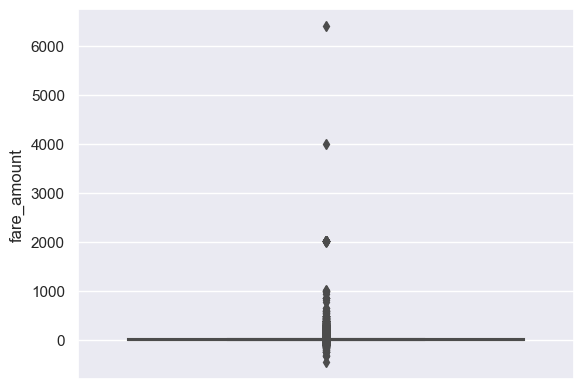

In [29]:
sns.boxplot(month_feb_2016_modified.to_pandas(), y = 'fare_amount')
plt.show()

In [30]:
fares = month_feb_2016_modified['fare_amount'].to_pandas()

deciles = [i * 10 for i in range(1, 11)]
percentile_values = np.percentile(fares, deciles)

for j, i in enumerate(range(10, 101, 10)):
    print(f'{i}th Percentile: {percentile_values[j]}')
    
print('================================================================================================\n')

percentiles = [i + 90 for i in range(0, 11)]
percentile_values = np.percentile(fares, percentiles)

for j, i in enumerate(range(90, 101)):
    print(f'{i}th Percentile: {percentile_values[j]}')
    
print('================================================================================================\n')

percentiles = [i / 10 for i in range(991, 1001)]
percentile_values = np.percentile(fares, percentiles)

for j, p in enumerate(percentiles):
    print(f'{p}th Percentile: {percentile_values[j]}')



10th Percentile: 5.0
20th Percentile: 6.0
30th Percentile: 7.0
40th Percentile: 8.0
50th Percentile: 9.0
60th Percentile: 10.5
70th Percentile: 12.5
80th Percentile: 16.0
90th Percentile: 23.5
100th Percentile: 6400.0

90th Percentile: 23.5
91th Percentile: 24.5
92th Percentile: 26.5
93th Percentile: 28.0
94th Percentile: 30.0
95th Percentile: 32.5
96th Percentile: 36.0
97th Percentile: 42.5
98th Percentile: 52.0
99th Percentile: 52.0
100th Percentile: 6400.0

99.1th Percentile: 52.0
99.2th Percentile: 52.0
99.3th Percentile: 52.0
99.4th Percentile: 52.0
99.5th Percentile: 52.5
99.6th Percentile: 56.5
99.7th Percentile: 61.0
99.8th Percentile: 67.5
99.9th Percentile: 78.0
100.0th Percentile: 6400.0


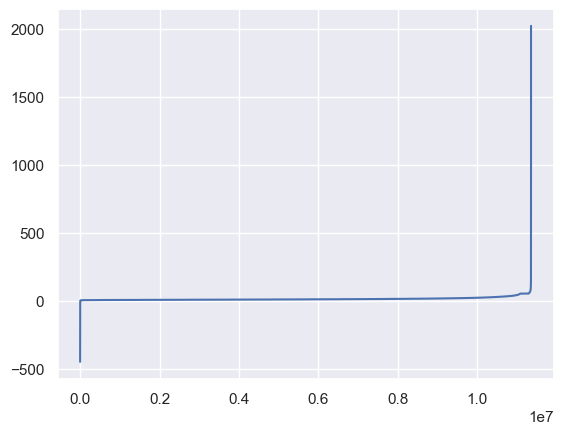

In [31]:
plt.plot(np.sort(fares.values)[:-2])
plt.show()

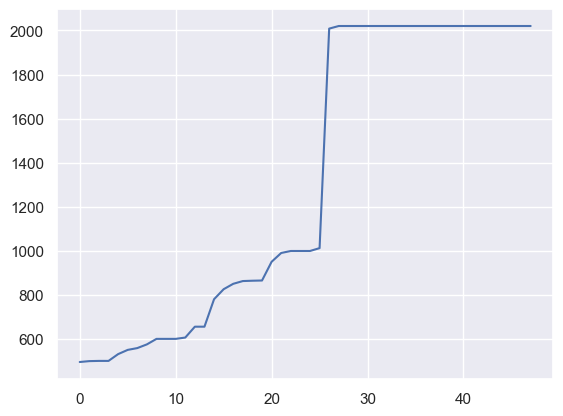

In [32]:
plt.plot(np.sort(fares.values)[-50:-2])
plt.show()

In [33]:
month_feb_2016_modified = month_feb_2016_modified.filter((pl.col('fare_amount') > 0) & (pl.col('fare_amount') <= 1000))
fare_amount_record_loss = total_records - month_feb_2016_modified.shape[0]
fare_amount_record_loss

30887

In [34]:
min_lat, max_lat = 40.4774, 40.9176
min_lon, max_lon = -74.2591, -73.7004

month_feb_2016_modified = month_feb_2016_modified.filter((pl.col('pickup_longitude') > min_lon) & (pl.col('pickup_longitude') < max_lon))
month_feb_2016_modified = month_feb_2016_modified.filter((pl.col('pickup_latitude') > min_lat) & (pl.col('pickup_latitude') < max_lat))
month_feb_2016_modified = month_feb_2016_modified.filter((pl.col('dropoff_longitude') > min_lon) & (pl.col('dropoff_longitude') < max_lon))
month_feb_2016_modified = month_feb_2016_modified.filter((pl.col('dropoff_latitude') > min_lat) & (pl.col('dropoff_latitude') < max_lat))

lattitude_longitude_record_loss = total_records - month_feb_2016_modified.shape[0]

In [35]:
print('Records Loss On Outliers Removal')
print('Distance:', trip_distances_record_loss)
print('Speed:', speed_record_loss)
print('Fare Amount:', fare_amount_record_loss)
print('NYC Region Lat vs Long: ', lattitude_longitude_record_loss)

total_records_loss = sum([trip_distances_record_loss, speed_record_loss, fare_amount_record_loss, lattitude_longitude_record_loss])
print('\nTotal Loss:', total_records_loss, 'out of', total_records)

percentage_lost = (total_records_loss * 100) / total_records
percentage_retained = 100 - percentage_lost

print('Percentage Retained:', round(percentage_retained, 3), 'Percentage Lost: ', round(100 - percentage_retained, 3))

Records Loss On Outliers Removal
Distance: 24169
Speed: 23660
Fare Amount: 30887
NYC Region Lat vs Long:  218580

Total Loss: 297296 out of 11382049
Percentage Retained: 97.388 Percentage Lost:  2.612


In [36]:
from sklearn.cluster import MiniBatchKMeans
import gpxpy.geo # for haversine distance

# Getting coordinates from Polars DataFrame
coords = month_feb_2016_modified.select([
    'pickup_latitude', 'pickup_longitude'
]).to_numpy()

# Will store nice cluster counts for each cluster size
neighbours = []

# Function to compute how many clusters are close to each other (i.e., within 2 miles)
def find_min_distance(cluster_centers, cluster_len):
    less2 = []       # Stores count of close clusters for each center less than 2 Mile
    more2 = []       # Stores count of far clusters for each center greater than 2 Mile
    min_dist = 10000  # Initialize with a large distance (used for tracking minimum)

    for i in range(cluster_len): # For each cluster center
        nice_points = 0  # Clusters with at least one nearby cluster (within 2 miles)
        wrong_points = 0 # Clusters with no nearby clusters
        for j in range(cluster_len): # Compare with every other cluster
            if j == i:
                continue # skip comparing with itself
            
            distance = gpxpy.geo.haversine_distance(
                cluster_centers[i][0], cluster_centers[i][1],
                cluster_centers[j][0], cluster_centers[j][1]
            )
            
            # Convert meters to miles and track minimum inter-cluster distance
            distance_miles = distance / (1.60934 * 1000)
            min_dist = min(min_dist, distance_miles)
            # Count as "nice" if distance is <= 2 Miles
            if distance_miles <= 2:
                nice_points += 1
            else:
                wrong_points += 1
                
        less2.append(nice_points)
        more2.append(wrong_points)
        
    # Store the nice-points data for analysis later
    neighbours.append(less2)
    
    avg_within_2 = np.mean(less2)
    avg_outside_2 = cluster_len - avg_within_2
    
    print('===============================================================================================================')
    print(f"On choosing a cluster size of {cluster_len}")
    print(f"Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): {round(avg_within_2, 2)}\
            {round(100 - (avg_outside_2 * 100 / cluster_len), 2)}%")
    print(f"Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): {round(avg_outside_2, 2)}")
    print(f"Min inter-cluster distance =  {round(min_dist, 3)} Gap {round(min_dist - 0.5 , 2)}")
    
# Function to apply MiniBatchKMeans clustering on pickup coordinates
def find_clusters(increment, dataframe):
    # Initialise and fit MiniBatchKMeans with 'increment' number of clusters
    kmeans = MiniBatchKMeans(
        n_clusters = increment, # Number of clusters to form
        batch_size = 10000,     # Mini-batch size for faster convergence
        random_state = 42,      # For reproducibility
    ).fit(coords)
    
    # Add cluster predictions as a new column to the Polars DataFrame
    dataframe = dataframe.with_columns([
        pl.Series(name = 'pickup_cluster', values = kmeans.predict(coords))
    ])
    
    # Extract the coordinates of cluster centers
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers) # Number of clusters (should be equal to increment)
    
    return cluster_centers, cluster_len

# Loop over different values of K (number of clusters)
for increment in range(10, 100, 10): # for k = 10 -> 100 by 10
    cluster_centers, cluster_len = find_clusters(increment, dataframe = month_feb_2016_modified)
    # Evaluate how tightly packed the clusters are (within 2 miles)
    find_min_distance(cluster_centers, cluster_len)

On choosing a cluster size of 10
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 2.2            22.0%
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 7.8
Min inter-cluster distance =  0.816 Gap 0.32
On choosing a cluster size of 20
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 5.2            26.0%
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 14.8
Min inter-cluster distance =  0.558 Gap 0.06
On choosing a cluster size of 30
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.27            27.56%
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 21.73
Min inter-cluster distance =  0.437 Gap -0.06
On choosing a cluster size of 40
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 10.5            26.25%
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 2

In [38]:
# Loop over different values of K (number of clusters)
for increment in range(30, 41): # for k = 30 -> 40 by 2
    cluster_centers, cluster_len = find_clusters(increment, dataframe = month_feb_2016_modified)
    # Evaluate how tightly packed the clusters are (within 2 miles)
    find_min_distance(cluster_centers, cluster_len)

On choosing a cluster size of 30
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.27            27.56%
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 21.73
Min inter-cluster distance =  0.437 Gap -0.06
On choosing a cluster size of 31
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 8.58            27.68%
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 22.42
Min inter-cluster distance =  0.388 Gap -0.11
On choosing a cluster size of 32
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 9.12            28.52%
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 22.88
Min inter-cluster distance =  0.429 Gap -0.07
On choosing a cluster size of 33
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 9.88            29.94%
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distanc

In [40]:
# We choose k = 33 it is close to 0.5-Mile Range with 29.94 % points less than 2.0-Miles Range
cluster_centers, cluster_len = find_clusters(33, dataframe = month_feb_2016_modified)
find_min_distance(cluster_centers, cluster_len)

On choosing a cluster size of 33
Avg. Number of Clusters within the vicinity (i.e. intercluster-distance < 2): 9.88            29.94%
Avg. Number of Clusters outside the vicinity (i.e. intercluster-distance > 2): 23.12
Min inter-cluster distance =  0.409 Gap -0.09


In [42]:
k = 33 # We choose k as 33 from analysis

# Perform MiniBatchKMeans clustering
kmeans = MiniBatchKMeans(n_clusters = k, batch_size = 1000000, random_state = 42).fit(coords)

# Get cluster centers
cluster_centers = kmeans.cluster_centers_

# Create a folium map centered around the mean of coordinates
map_center = [coords[:, 0].mean(), coords[:, 1].mean()]
map_clusters = folium.Map(location = map_center, zoom_start = 12)

# Add cluster centers to the map
for i, (lat, lon) in enumerate(cluster_centers):
    folium.Marker(
        location = [lat, lon],
        popup = f'Cluster {i + 1}',
        icon = folium.Icon(color = 'blue', icon = 'info-sign')
    ).add_to(map_clusters)
    
map_clusters.save('maps/cluster_center_map_feb.html')
print('Map Exported')

Map Exported


/var/folders/xt/dsl_68w51jzftxq18_hpfkhm0000gn/T/ipykernel_98559/3012939886.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', k)


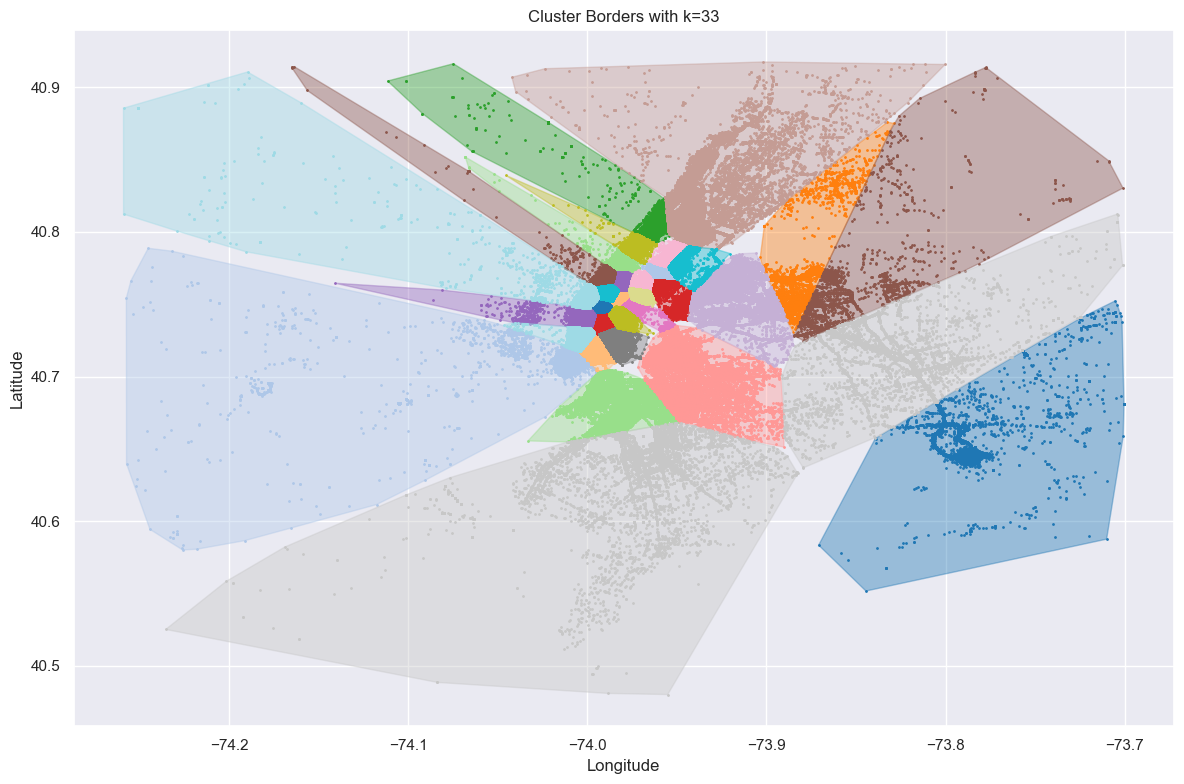

In [51]:
from scipy.spatial import ConvexHull
import matplotlib.cm as cm

labels = kmeans.labels_

# Create color map
colors = cm.get_cmap('tab20', k)

# Plot
plt.figure(figsize = (12, 8))

for i in range(k):
    cluster_points = coords[labels == i]
    
    # Only draw convex hulls if enough points
    if len(cluster_points) >= 3:
        hull = ConvexHull(cluster_points)
        hull_points = cluster_points[hull.vertices]
        plt.fill(hull_points[:, 1], hull_points[:, 0], alpha = 0.4, color = colors(i))

    # Scatter the points too
    plt.scatter(cluster_points[:, 1], cluster_points[:, 0], s = 1, color = colors(i))
    
month_jan_2016_modified = month_feb_2016_modified.with_columns([
    pl.Series('pickup_cluster', labels)
])
    
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Cluster Borders with k={k}")
plt.grid(True)
plt.tight_layout()
plt.show()

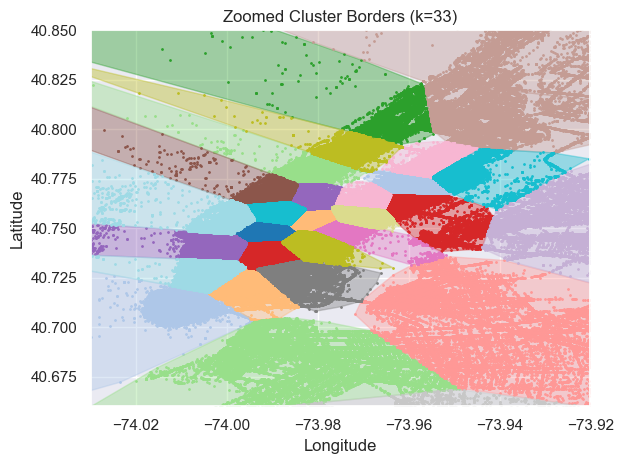

In [52]:
for i in range(k):
    cluster_points = coords[labels == i]

    # Only draw convex hulls if enough points
    if len(cluster_points) >= 3:
        hull = ConvexHull(cluster_points)
        hull_points = cluster_points[hull.vertices]
        plt.fill(hull_points[:, 1], hull_points[:, 0], alpha=0.4, color=colors(i))

    # Plot points
    plt.scatter(cluster_points[:, 1], cluster_points[:, 0], s=1, color=colors(i))

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"Zoomed Cluster Borders (k={k})")

# 🔍 Zoom into dense Manhattan region (adjust values based on your data)
plt.xlim(-74.03, -73.92)   # Longitude
plt.ylim(40.66, 40.85)     # Latitude

plt.grid(True)
plt.tight_layout()
plt.show()

In [47]:
def bin_unix_time(df: pl.DataFrame, column_name: str, bin_size_seconds: int) -> pl.DataFrame:
    return df.with_columns([
        (pl.col(column_name) // bin_size_seconds * bin_size_seconds).alias(f'{column_name}_binned')
    ])

# Apply time binning
month_feb_2016_modified = bin_unix_time(month_feb_2016_modified, 'pickup_unix', 600)

# Convert binned seconds to datetime (in milliseconds)
month_feb_2016_modified = month_feb_2016_modified.with_columns(
    (pl.col("pickup_unix_binned") * 1000)
    .cast(pl.Datetime("ms"))
    .alias("pickup_binned_datetime")
)

In [53]:
month_feb_2016_modified.schema

Schema([('VendorID', Int64),
        ('tpep_pickup_datetime', String),
        ('tpep_dropoff_datetime', String),
        ('passenger_count', Int64),
        ('trip_distance', Float64),
        ('pickup_longitude', Float64),
        ('pickup_latitude', Float64),
        ('RatecodeID', Int64),
        ('store_and_fwd_flag', String),
        ('dropoff_longitude', Float64),
        ('dropoff_latitude', Float64),
        ('payment_type', Int64),
        ('fare_amount', Float64),
        ('extra', Float64),
        ('mta_tax', Float64),
        ('tip_amount', Float64),
        ('tolls_amount', Float64),
        ('improvement_surcharge', Float64),
        ('total_amount', Float64),
        ('pickup_unix', Float64),
        ('dropoff_unix', Float64),
        ('trip_times', Float64),
        ('speed', Float64),
        ('log_trip_times', Float64),
        ('pickup_unix_binned', Float64),
        ('pickup_binned_datetime', Datetime(time_unit='ms', time_zone=None))])

In [48]:
cluster_bin_freq = (
    month_feb_2016_modified
    .select(['pickup_cluster', 'pickup_unix_binned'])
    .unique()
    .group_by('pickup_cluster')
    .agg([
        pl.count().alias('nums_10min_intervals')
    ])
)

total = 0
for row in cluster_bin_freq.iter_rows():
    cluster_id, num_bins = row
    print(f"For cluster {cluster_id}, there are {num_bins} bins.")

ColumnNotFoundError: pickup_cluster

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sink' <---
DF ["VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", ...]; PROJECT */26 COLUMNS

In [54]:
# Calculate lower and upper thresholds for "trip_times" (e.g., 1st and 99th percentile)
lower_threshold = month_feb_2016_modified.select(
    pl.col("trip_times").quantile(0.01).alias("lower_threshold")
).to_series()[0]

upper_threshold = month_feb_2016_modified.select(
    pl.col("trip_times").quantile(0.99).alias("upper_threshold")
).to_series()[0]

print("Lower threshold:", lower_threshold)
print("Upper threshold:", upper_threshold)

# Cap the outliers in "trip_times" by winsorizing, and store the result in a new column "trip_times_capped"
month_feb_2016_modified = month_feb_2016_modified.with_columns(
    pl.when(pl.col("trip_times") < lower_threshold)
      .then(lower_threshold)
      .when(pl.col("trip_times") > upper_threshold)
      .then(upper_threshold)
      .otherwise(pl.col("trip_times"))
      .alias("trip_times_capped")
)

# Optional: Display a few rows to verify the changes
print(month_feb_2016_modified.select(["trip_times", "trip_times_capped"]).head())

Lower threshold: 1.5166666666666666
Upper threshold: 50.983333333333334
shape: (5, 2)
┌────────────┬───────────────────┐
│ trip_times ┆ trip_times_capped │
│ ---        ┆ ---               │
│ f64        ┆ f64               │
╞════════════╪═══════════════════╡
│ 3.0        ┆ 3.0               │
│ 21.0       ┆ 21.0              │
│ 10.85      ┆ 10.85             │
│ 5.2        ┆ 5.2               │
│ 20.9       ┆ 20.9              │
└────────────┴───────────────────┘


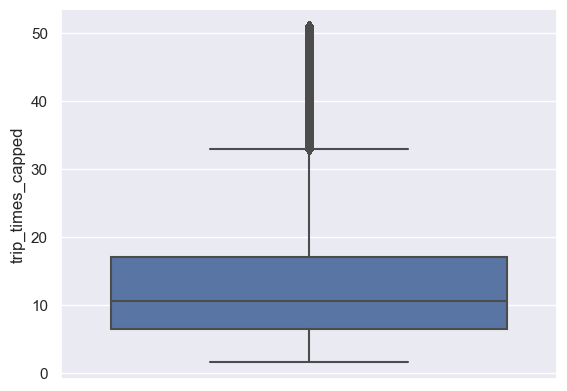

In [55]:
# Calculate the percentiles to remove outliers, and check with BoxPlots
import seaborn as sns
import matplotlib.pyplot as plt

# Convert Polars DataFrame to Pandas for plotting
sns.boxplot(data = month_feb_2016_modified.to_pandas(), y = "trip_times_capped")
plt.show()

In [58]:
output_df = (
    month_feb_2016_modified
    .group_by(['pickup_cluster', 'pickup_unix_binned', 'pickup_binned_datetime', 'trip_times_capped'])
    .agg(pl.count().alias('num_pickups'))
    .sort('pickup_unix_binned')
)

output_df.write_csv('Training_And_Testing/feb_2016.csv')

/var/folders/xt/dsl_68w51jzftxq18_hpfkhm0000gn/T/ipykernel_98559/3127933655.py:4: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias('num_pickups'))


ColumnNotFoundError: pickup_cluster

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'sink' <---
DF ["VendorID", "tpep_pickup_datetime", "tpep_dropoff_datetime", "passenger_count", ...]; PROJECT */27 COLUMNS